# Modelová úloha - vzdálenosti mezi body v 3D
Zadání: pro N bodů v 3 rozměrném prostoru spočítejte vzájemnou vzdálenost $d$, která je pro dva body $x,y$ definovaná jako $\sqrt {\sum_{i=1}^3 {{{\left( {{x_i} - {y_i}} \right)}^2}} } $. Výslekem je tedy (symetrická) matice $N\times N$.

In [15]:
import numpy as np
points_count = 1000
points_np = np.random.rand(points_count, 3)

## Numba - sériová verze

Viz minulá hodina.

In [2]:
import math
import numba

@numba.jit(nopython=True)
def dist_numba(points):
    n = points.shape[0]
    distances_all = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            tmp_sum = 0
            for k in range(3):
                rozdil = points[i, k] - points[j, k]
                tmp_sum += rozdil*rozdil
            tmp_dist = math.sqrt(tmp_sum)
            distances_all[i, j] = tmp_dist
            distances_all[j, i] = tmp_dist

    return distances_all

In [3]:
%time _ = dist_numba(points_np)

CPU times: user 1.52 s, sys: 40.3 ms, total: 1.56 s
Wall time: 660 ms


In [4]:
%timeit _ = dist_numba(points_np)

1.75 ms ± 520 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Cython - sériová verze
- použijeme Jupyter cell magic `%%cython`
- `--compile-args=-O3` - optimalizace při kompilaci
- `--compile-args=-w` - potlačení warningů (deprecated API)

In [5]:
%load_ext Cython

In [6]:
%%cython --compile-args=-O3 --compile-args=-w

import numpy as np  # pythoní numpy
cimport numpy as cnp  # cythoní numpy pro statické typování
from libc.math cimport sqrt
cimport cython

ctypedef cnp.float64_t DTYPE_t  # alias pro typ float64

@cython.boundscheck(False)  # vypnutí kontrol přístupu mimo pole -> chyba = segfault
@cython.wraparound(False)  # vypnutí záporných indexů -> chyba = segfault
def dist_cython(cnp.ndarray[DTYPE_t, ndim=2] points):
    cdef int n = points.shape[0]
    cdef cnp.ndarray[DTYPE_t, ndim=2] distances_all = np.zeros((n, n), dtype=np.float64)
    cdef int i, j, k  # všechny iterační proměnné musí být definované
    cdef DTYPE_t tmp_sum, rozdil, tmp_dist  # pomocné proměnné

    for i in range(n):
        for j in range(i+1, n):
            tmp_sum = 0
            for k in range(3):
                rozdil = points[i, k] - points[j, k]
                tmp_sum += rozdil * rozdil
            tmp_dist = sqrt(tmp_sum)
            distances_all[i, j] = tmp_dist
            distances_all[j, i] = tmp_dist

    return distances_all

In [20]:
%timeit _ = dist_cython(points_np)

1.17 ms ± 8.13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
# vyzkoušíme si, jestli to funguje
res1 = dist_numba(points_np)
res2 = dist_cython(points_np)
np.allclose(res1, res2)

True

## Porovnání nejlepších variant

64 0.0002884864807128906 2.3365020751953125e-05
128 4.8160552978515625e-05 4.649162292480469e-05
256 0.00018358230590820312 0.0001690387725830078
512 0.0013990402221679688 0.0014748573303222656
1024 0.008197307586669922 0.005162477493286133
2048 0.039624691009521484 0.0312497615814209
4096 0.2707977294921875 0.18619990348815918
8192 1.2771496772766113 0.8319547176361084
16384 7.372196912765503 4.658719062805176


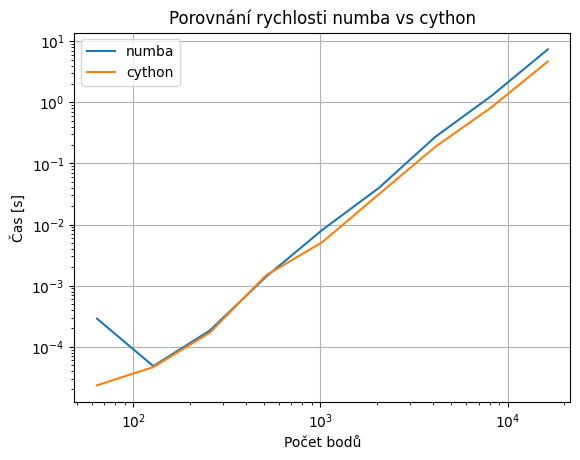

In [9]:
import time
import matplotlib.pyplot as plt

velikosti = [2**i for i in range(6, 15)]
time_numba = []
time_cython = []

for n in velikosti:
    points_np = np.random.rand(n, 3)

    start = time.time()
    _ = dist_numba(points_np)
    time_numba.append(time.time() - start)

    start = time.time()
    _ = dist_cython(points_np)
    time_cython.append(time.time() - start)

    print(n, time_numba[-1], time_cython[-1])

# log-log grafy
plt.loglog(velikosti, time_numba, label="numba")
plt.loglog(velikosti, time_cython, label="cython")
plt.xlabel("Počet bodů")
plt.ylabel("Čas [s]")
plt.grid()
plt.title("Porovnání rychlosti numba vs cython")
plt.legend()

# Paralelní implementace:

In [13]:
points_count = 1000
points_np = np.random.rand(points_count, 3)

## Numba - paralelní verze

- stačí nám tag `parallel=True` a `prange` místo `range`

In [10]:
@numba.jit(nopython=True, parallel=True)
def dist_numba_parallel(points):
    n = points.shape[0]
    distances_all = np.zeros((n, n))
    for i in numba.prange(n):
        for j in numba.prange(i + 1, n):
            tmp_sum = 0
            for k in range(3):
                rozdil = points[i, k] - points[j, k]
                tmp_sum += rozdil*rozdil
            tmp_dist = math.sqrt(tmp_sum)
            distances_all[i, j] = tmp_dist
            distances_all[j, i] = tmp_dist

    return distances_all

In [11]:
%time _ = dist_numba_parallel(points_np)

CPU times: user 10.1 s, sys: 2.47 s, total: 12.6 s
Wall time: 3.12 s


In [14]:
%timeit _ = dist_numba_parallel(points_np)

373 µs ± 119 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Cython - paralelní verze

Verze s redundatním výpočtem vzdálenosti mezi body, bude se lépe paralelizovat.

In [ ]:
%%cython --compile-args=-O3

import numpy as np
cimport numpy as np
from libc.math cimport sqrt
cimport cython

ctypedef np.float64_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef dist_cython_serial_2(np.ndarray[DTYPE_t, ndim=2] points):
    cdef int n = points.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=2] distances_all = np.zeros((n, n), dtype=np.float64)
    cdef int i, j, k
    cdef double tmp_sum, rozdil, tmp_dist

    for i in range(n):
        for j in range(n):
            tmp_sum = 0
            for k in range(3):
                rozdil = points[i, k] - points[j, k]
                tmp_sum += rozdil * rozdil
            tmp_dist = sqrt(tmp_sum)
            distances_all[i, j] = tmp_dist

    
    return distances_all


#### Cython s paralelizací pomocí `prange()`

In [ ]:
%%cython --compile-args=-fopenmp --compile-args=-O3 --link-args=-fopenmp

import numpy as np
cimport numpy as np
from libc.math cimport sqrt
cimport cython
from cython.parallel import parallel, prange # toto je zde nové

ctypedef np.float64_t DTYPE_t

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef dist_cython_paralell(np.ndarray[DTYPE_t, ndim=2] points, int n_threads):
    cdef int n = points.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=2] distances_all = np.zeros((n, n), dtype=np.float64)
    cdef int i, j, k
    cdef double tmp_sum, rozdil, tmp_dist


    for i in prange(n, nogil=True, num_threads=n_threads): # toto je zde nové
        for j in range(n):
            tmp_sum = 0  # Reset tmp_sum for each new pair of points
            for k in range(3):
                rozdil = points[i, k] - points[j, k]
                tmp_sum = tmp_sum + rozdil * rozdil # toto je zde nové
            tmp_dist = sqrt(tmp_sum)
            distances_all[i, j] = tmp_dist

    return distances_all




In [ ]:
import numpy as np

# vyzkoušíme si, jak to funguje
points_np = np.random.rand(2**13, 3)

In [ ]:
%timeit _ = dist_cython_serial_1(points_np)


In [ ]:
%timeit _ = dist_cython_serial_2(points_np)

In [ ]:
%timeit _ = dist_cython_paralell(points_np,32)

In [ ]:
import time
import matplotlib.pyplot as plt

pocet_vlaken =[2**i for i in range(10, 14)]
time_cython_serial_1 = []
time_cython_serial_2 = []

all_num_threads = [2, 4, 8, 16, 32, 64, 128]
time_cython_parallel = [[] for _ in all_num_threads]



n_loops = 10

def measure_multi(n,func):
    tmp_time = []
    for i in range(n):
        start = time.time()
        _ = func(points_np)
        tmp_time.append(time.time() - start)
    return min(tmp_time)

for n in pocet_vlaken:
    points_np = np.random.rand(n, 3)
    
    time_cython_serial_1.append(measure_multi(n_loops, dist_cython_serial_1))
    time_cython_serial_2.append(measure_multi(n_loops, dist_cython_serial_2))

    for idx, n_threads in enumerate(all_num_threads):
        time_cython_parallel[idx].append(measure_multi(n_loops, lambda points_np : dist_cython_paralell(points_np, n_threads)))


    min_time = min([time_cython_parallel[idx][-1] for idx, _ in enumerate(all_num_threads)])
    ratio = time_cython_serial_2[-1]/min_time
    print(f"velikost {n}, čas sekvenční {time_cython_serial_2[-1]}, nejlepší paralelní {min_time}, poměr {ratio}")

# log-log grafy
plt.loglog(pocet_vlaken, time_cython_serial_1, label='serial 1')
plt.loglog(pocet_vlaken, time_cython_serial_2, label='serial 2')
for idx, n_threads in enumerate(all_num_threads):
    plt.loglog(pocet_vlaken, time_cython_parallel[idx], label='paralell' + str(n_threads))

plt.legend()

## Proč je verze serial_1 tak pomalá?

Důvodem je ukládání do pole, které pří indexech `[i, j] a [j, i]` zaručeně v jednom případě přistupuje do paměti v pořadí, které není sekvenční. To způsobuje, že se využívá cache paměti méně efektivně.

Vyhodíme z výpočtu zápis na index `[j, i]`, tedy výstup bude horní trojúhelníková matice.

In [ ]:
%%cython --compile-args=-O3

import numpy as np
cimport numpy as np
from libc.math cimport sqrt
cimport cython

ctypedef np.float64_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef dist_cython_serial_1(np.ndarray[DTYPE_t, ndim=2] points):
    cdef int n = points.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=2] distances_all = np.zeros((n, n), dtype=np.float64)
    cdef int i, j, k
    cdef double tmp_sum, rozdil, tmp_dist

    for i in range(n):
        for j in range(i+1, n):
            tmp_sum = 0
            for k in range(3):
                rozdil = points[i, k] - points[j, k]
                tmp_sum += rozdil * rozdil
            tmp_dist = sqrt(tmp_sum)
            distances_all[i, j] = tmp_dist

    
    return distances_all


Ozkoušíme benchmarking znova:

In [ ]:
import time
import matplotlib.pyplot as plt

pocet_vlaken =[2**i for i in range(10, 14)]
time_cython_serial_1 = []
time_cython_serial_2 = []

all_num_threads = [2, 4, 8, 16, 32, 64, 128]
time_cython_parallel = [[] for _ in all_num_threads]



n_loops = 10

def measure_multi(n,func):
    tmp_time = []
    for i in range(n):
        start = time.time()
        _ = func(points_np)
        tmp_time.append(time.time() - start)
    return min(tmp_time)

for n in pocet_vlaken:
    points_np = np.random.rand(n, 3)
    
    time_cython_serial_1.append(measure_multi(n_loops, dist_cython_serial_1))
    time_cython_serial_2.append(measure_multi(n_loops, dist_cython_serial_2))

    for idx, n_threads in enumerate(all_num_threads):
        time_cython_parallel[idx].append(measure_multi(n_loops, lambda points_np : dist_cython_paralell(points_np, n_threads)))


    min_time = min([time_cython_parallel[idx][-1] for idx, _ in enumerate(all_num_threads)])
    ratio = time_cython_serial_2[-1]/min_time
    print(f"velikost {n}, čas sekvenční {time_cython_serial_2[-1]}, nejlepší paralelní {min_time}, poměr {ratio}")

# log-log grafy
plt.loglog(pocet_vlaken, time_cython_serial_1, label='serial 1')
plt.loglog(pocet_vlaken, time_cython_serial_2, label='serial 2')
for idx, n_threads in enumerate(all_num_threads):
    plt.loglog(pocet_vlaken, time_cython_parallel[idx], label='paralell' + str(n_threads))

plt.legend()